# Import libraries and define functions + Initial setup

In [22]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import csv


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [23]:
'''
name: relative_transcript_abundance

purpose: calculate relative transcript abundance

input: a dataframe with a ref_gene_id column identifying the transcript gene of origin and a cov columns with 
the coverage for the transcripts.

output: the same dataframe with a relative abundance column added
'''



def relative_transcript_abundance(df):
    
    ## Group by gene_id and get total expression for each gene (not counting introns)
    df_sums = df[["gene_id", "total_CPM"]].groupby("gene_id").sum()
    df_sums["total_CPM_gene"] = df_sums["total_CPM"]
    df_sums.drop(columns="total_CPM", inplace=True)
    
    ## Merge dataframe with total gene level CPM with regular transcript level CPM dataframe
    merged_df = pd.merge(df, df_sums, how='inner', on="gene_id")
    
    ## Calculater relative percent abundance for each transcript within its gene
    merged_df["relative_abundance_percent"] = ((merged_df["total_CPM"]/merged_df["total_CPM_gene"]) * 100)
    
    ## Rename total_CPM for transcript column
    merged_df["total_CPM_transcript"] = merged_df["total_CPM"]
    merged_df.drop(columns="total_CPM", inplace=True)


    return merged_df

In [24]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = df.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        df["gene_id"] = df.index
        cols = list(df.columns)
        cols = [cols[-1]] + cols[:-1]
        df = df[cols]
        df.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = df.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    df.columns = list_new_names
    
    return df 

In [25]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True, is_transcript=False, is_prot=False, delete_other=True):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]
        
        ## Get get transcript biotype
        df["gene_biotype"] = df["other"].str.split('gene_biotype "', expand=True)[1].str.split('"', expand=True)[0]
        
        ## If is transcript get transcript id and transcript biotype
        if is_transcript:
            df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
            df["transcript_biotype"] = df["other"].str.split('transcript_biotype "', expand=True)[1].str.split('"', expand=True)[0]
            
            ## If is prot get protein_id
            if is_prot:
                df["protein_id"] = df["other"].str.split('protein_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["ccds_id"] = df["other"].str.split('ccds_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)
        

    else:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        if delete_other:
            df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [26]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = df.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = df.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in count_columns:
        
        df[col] = round(df[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        df[cpm_name] = round(((df[col]/(df[col].sum())) * 1000000), 2)
    
    return df  

In [27]:
## define ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

## - Read matrices and make graphs

In [28]:
## Read matrices

df_2 = pd.read_csv("../../../data/raw/1st_rebuttal_data/OURS_GRCh38-107_discovery_subsample_0.2/bambu_discovery/counts_transcript.txt",
                      sep="\t")

df_4 = pd.read_csv("../../../data/raw/1st_rebuttal_data/OURS_GRCh38-107_discovery_subsample_0.4/bambu_discovery/counts_transcript.txt",
                      sep="\t")

df_6 = pd.read_csv("../../../data/raw/1st_rebuttal_data/OURS_GRCh38-107_discovery_subsample_0.6/bambu_discovery/counts_transcript.txt",
                      sep="\t")

df_8 = pd.read_csv("../../../data/raw/1st_rebuttal_data/OURS_GRCh38-107_discovery_subsample_0.8/bambu_discovery/counts_transcript.txt",
                      sep="\t")

df_10 = pd.read_csv("../../../data/raw/nextflow_pipeline_output/bambu_discovery/counts_transcript.txt",
                      sep="\t")

In [29]:
## Read matrices

df_2_full = pd.read_csv("../../../data/raw/1st_rebuttal_data/OURS_GRCh38-107_discovery_subsample_0.2/bambu_discovery/fullLengthCounts_transcript.txt",
                      sep="\t")

df_4_full = pd.read_csv("../../../data/raw/1st_rebuttal_data/OURS_GRCh38-107_discovery_subsample_0.4/bambu_discovery/fullLengthCounts_transcript.txt",
                      sep="\t")

df_6_full = pd.read_csv("../../../data/raw/1st_rebuttal_data/OURS_GRCh38-107_discovery_subsample_0.6/bambu_discovery/fullLengthCounts_transcript.txt",
                      sep="\t")

df_8_full = pd.read_csv("../../../data/raw/1st_rebuttal_data/OURS_GRCh38-107_discovery_subsample_0.8/bambu_discovery/fullLengthCounts_transcript.txt",
                      sep="\t")

df_10_full = pd.read_csv("../../../data/raw/nextflow_pipeline_output/bambu_discovery/fullLengthCounts_transcript.txt",
                      sep="\t")

In [30]:
## Fix column names

df_2 = fix_column_names(df_2, is_gene=False)
df_4 = fix_column_names(df_4, is_gene=False)
df_6 = fix_column_names(df_6, is_gene=False)
df_8 = fix_column_names(df_8, is_gene=False)
df_10 = fix_column_names(df_10, is_gene=False)

df_2_full = fix_column_names(df_2_full, is_gene=False)
df_4_full = fix_column_names(df_4_full, is_gene=False)
df_6_full = fix_column_names(df_6_full, is_gene=False)
df_8_full = fix_column_names(df_8_full, is_gene=False)
df_10_full = fix_column_names(df_10_full, is_gene=False)

In [31]:
## Calculate CPM, drop counts, calculate median CPM (only on regular counts matrix)

df_2 = calculate_cpm(df_2, is_gene=False)
df_4 = calculate_cpm(df_4, is_gene=False)
df_6 = calculate_cpm(df_6, is_gene=False)
df_8 = calculate_cpm(df_8, is_gene=False)
df_10 = calculate_cpm(df_10, is_gene=False)

df_2 = df_2[df_2.columns.drop(list(df_2.filter(regex='counts')))].copy()
df_4 = df_4[df_4.columns.drop(list(df_4.filter(regex='counts')))].copy()
df_6 = df_6[df_6.columns.drop(list(df_6.filter(regex='counts')))].copy()
df_8 = df_8[df_8.columns.drop(list(df_8.filter(regex='counts')))].copy()
df_10 = df_10[df_10.columns.drop(list(df_10.filter(regex='counts')))].copy()


df_2["median_CPM"] = df_2[df_2.filter(regex='[0-9]_CPM').columns].median(axis=1)
df_4["median_CPM"] = df_4[df_4.filter(regex='[0-9]_CPM').columns].median(axis=1)
df_6["median_CPM"] = df_6[df_6.filter(regex='[0-9]_CPM').columns].median(axis=1)
df_8["median_CPM"] = df_8[df_8.filter(regex='[0-9]_CPM').columns].median(axis=1)
df_10["median_CPM"] = df_10[df_10.filter(regex='[0-9]_CPM').columns].median(axis=1)

In [32]:
## Calculate median counts for full-lenth matrixes

df_2_full["median_counts"] = df_2_full[df_2_full.filter(regex='counts').columns].median(axis=1)
df_4_full["median_counts"] = df_4_full[df_4_full.filter(regex='counts').columns].median(axis=1)
df_6_full["median_counts"] = df_6_full[df_6_full.filter(regex='counts').columns].median(axis=1)
df_8_full["median_counts"] = df_8_full[df_8_full.filter(regex='counts').columns].median(axis=1)
df_10_full["median_counts"] = df_10_full[df_10_full.filter(regex='counts').columns].median(axis=1)

In [33]:
## Load references

ref_2 = pd.read_csv("../../../data/raw/1st_rebuttal_data/OURS_GRCh38-107_discovery_subsample_0.2/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])
ref_2 = parse_df_columns(ref_2, is_ref=False)
ref_2 = ref_2.loc[ref_2["type"] == "transcript"][["transcript_id", "chr"]].copy()


ref_4 = pd.read_csv("../../../data/raw/1st_rebuttal_data/OURS_GRCh38-107_discovery_subsample_0.4/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])
ref_4 = parse_df_columns(ref_4, is_ref=False)
ref_4 = ref_4.loc[ref_4["type"] == "transcript"][["transcript_id", "chr"]].copy()


ref_6 = pd.read_csv("../../../data/raw/1st_rebuttal_data/OURS_GRCh38-107_discovery_subsample_0.6/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])
ref_6 = parse_df_columns(ref_6, is_ref=False)
ref_6 = ref_6.loc[ref_6["type"] == "transcript"][["transcript_id", "chr"]].copy()


ref_8 = pd.read_csv("../../../data/raw/1st_rebuttal_data/OURS_GRCh38-107_discovery_subsample_0.8/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])
ref_8 = parse_df_columns(ref_8, is_ref=False)
ref_8 = ref_8.loc[ref_8["type"] == "transcript"][["transcript_id", "chr"]].copy()


ref_10 = pd.read_csv("../../../data/raw/nextflow_pipeline_output/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])
ref_10 = parse_df_columns(ref_10, is_ref=False)
ref_10 = ref_10.loc[ref_10["type"] == "transcript"][["transcript_id", "chr"]].copy()

In [34]:
## Add chromosome information

df_2 = df_2.merge(ref_2, on="transcript_id", how="inner")
df_4 = df_4.merge(ref_4, on="transcript_id", how="inner")
df_6 = df_6.merge(ref_6, on="transcript_id", how="inner")
df_8 = df_8.merge(ref_8, on="transcript_id", how="inner")
df_10 = df_10.merge(ref_10, on="transcript_id", how="inner")

df_2_full = df_2_full.merge(ref_2, on="transcript_id", how="inner")
df_4_full = df_4_full.merge(ref_4, on="transcript_id", how="inner")
df_6_full = df_6_full.merge(ref_6, on="transcript_id", how="inner")
df_8_full = df_8_full.merge(ref_8, on="transcript_id", how="inner")
df_10_full = df_10_full.merge(ref_10, on="transcript_id", how="inner")

In [35]:
## Remove transcripts from wrong chromosome

df_2 = df_2.loc[df_2["chr"] != "MT"].copy()
df_4 = df_4.loc[df_4["chr"] != "MT"].copy()
df_6 = df_6.loc[df_6["chr"] != "MT"].copy()
df_8 = df_8.loc[df_8["chr"] != "MT"].copy()
df_10 = df_10.loc[df_10["chr"] != "MT"].copy()

df_2_full = df_2_full.loc[df_2_full["chr"] == "MT"].copy()
df_4_full = df_4_full.loc[df_4_full["chr"] == "MT"].copy()
df_6_full = df_6_full.loc[df_6_full["chr"] == "MT"].copy()
df_8_full = df_8_full.loc[df_8_full["chr"] == "MT"].copy()
df_10_full = df_10_full.loc[df_10_full["chr"] == "MT"].copy()

In [36]:
## Only keep transcripts passing threshold

df_2 = df_2.loc[df_2["median_CPM"] > 1].copy()
df_4 = df_4.loc[df_4["median_CPM"] > 1].copy()
df_6 = df_6.loc[df_6["median_CPM"] > 1].copy()
df_8 = df_8.loc[df_8["median_CPM"] > 1].copy()
df_10 = df_10.loc[df_10["median_CPM"] > 1].copy()

df_2_full = df_2_full.loc[df_2_full["median_counts"] > 40].copy()
df_4_full = df_4_full.loc[df_4_full["median_counts"] > 40].copy()
df_6_full = df_6_full.loc[df_6_full["median_counts"] > 40].copy()
df_8_full = df_8_full.loc[df_8_full["median_counts"] > 40].copy()
df_10_full = df_10_full.loc[df_10_full["median_counts"] > 40].copy()

In [37]:
## Calculate numbers

all_2 = df_2.loc[df_2["transcript_id"].str.startswith("Bambu")].shape[0]
nfk_2 = df_2.loc[((~df_2["gene_id"].str.startswith("Bambu")) & (df_2["transcript_id"].str.startswith("Bambu")) & (df_2["chr"] != "MT"))].shape[0]
nfn_2 = df_2.loc[df_2["gene_id"].str.startswith("Bambu")].shape[0]
nfm_2 = df_2_full.loc[((df_2_full["transcript_id"].str.startswith("Bambu")) & (df_2_full["chr"] == "MT"))].shape[0]

all_4 = df_4.loc[df_4["transcript_id"].str.startswith("Bambu")].shape[0]
nfk_4 = df_4.loc[((~df_4["gene_id"].str.startswith("Bambu")) & (df_4["transcript_id"].str.startswith("Bambu")) & (df_4["chr"] != "MT"))].shape[0]
nfn_4 = df_4.loc[df_4["gene_id"].str.startswith("Bambu")].shape[0]
nfm_4 = df_4_full.loc[((df_4_full["transcript_id"].str.startswith("Bambu")) & (df_4_full["chr"] == "MT"))].shape[0]

all_6 = df_6.loc[df_6["transcript_id"].str.startswith("Bambu")].shape[0]
nfk_6 = df_6.loc[((~df_6["gene_id"].str.startswith("Bambu")) & (df_6["transcript_id"].str.startswith("Bambu")) & (df_6["chr"] != "MT"))].shape[0]
nfn_6 = df_6.loc[df_6["gene_id"].str.startswith("Bambu")].shape[0]
nfm_6 = df_6_full.loc[((df_6_full["transcript_id"].str.startswith("Bambu")) & (df_6_full["chr"] == "MT"))].shape[0]

all_8 = df_8.loc[df_8["transcript_id"].str.startswith("Bambu")].shape[0]
nfk_8 = df_8.loc[((~df_8["gene_id"].str.startswith("Bambu")) & (df_8["transcript_id"].str.startswith("Bambu")) & (df_8["chr"] != "MT"))].shape[0]
nfn_8 = df_8.loc[df_8["gene_id"].str.startswith("Bambu")].shape[0]
nfm_8 = df_8_full.loc[((df_8_full["transcript_id"].str.startswith("Bambu")) & (df_8_full["chr"] == "MT"))].shape[0]

all_10 = df_10.loc[df_10["transcript_id"].str.startswith("Bambu")].shape[0]
nfk_10 = df_10.loc[((~df_10["gene_id"].str.startswith("Bambu")) & (df_10["transcript_id"].str.startswith("Bambu")) & (df_10["chr"] != "MT"))].shape[0]
nfn_10 = df_10.loc[df_10["gene_id"].str.startswith("Bambu")].shape[0]
nfm_10 = df_10_full.loc[((df_10_full["transcript_id"].str.startswith("Bambu")) & (df_10_full["chr"] == "MT"))].shape[0]

In [38]:
print("All new transcripts for 20% subsamples:", all_2)
print("New transcripts from known genes for 20% subsamples:", nfk_2)
print("New transcripts from new genes for 20% subsamples:", nfn_2)
print("New mitochondrially encoded spliced transcripts for 20% subsamples:", nfm_2)

All new transcripts for 20% subsamples: 374
New transcripts from known genes for 20% subsamples: 238
New transcripts from new genes for 20% subsamples: 136
New mitochondrially encoded spliced transcripts for 20% subsamples: 2


In [39]:
print("All new transcripts for 40% subsamples:", all_4)
print("New transcripts from known genes for 40% subsamples:", nfk_4)
print("New transcripts from new genes for 40% subsamples:", nfn_4)
print("New mitochondrially encoded spliced transcripts for 40% subsamples:", nfm_4)

All new transcripts for 40% subsamples: 498
New transcripts from known genes for 40% subsamples: 312
New transcripts from new genes for 40% subsamples: 186
New mitochondrially encoded spliced transcripts for 40% subsamples: 3


In [40]:
print("All new transcripts for 60% subsamples:", all_6)
print("New transcripts from known genes for 60% subsamples:", nfk_6)
print("New transcripts from new genes for 60% subsamples:", nfn_6)
print("New mitochondrially encoded spliced transcripts for 60% subsamples:", nfm_6)

All new transcripts for 60% subsamples: 552
New transcripts from known genes for 60% subsamples: 344
New transcripts from new genes for 60% subsamples: 208
New mitochondrially encoded spliced transcripts for 60% subsamples: 3


In [41]:
print("All new transcripts for 80% subsamples:", all_8)
print("New transcripts from known genes for 80% subsamples:", nfk_8)
print("New transcripts from new genes for 80% subsample:", nfn_8)
print("New mitochondrially encoded spliced transcripts for 80% subsamples:", nfm_8)

All new transcripts for 80% subsamples: 665
New transcripts from known genes for 80% subsamples: 421
New transcripts from new genes for 80% subsample: 244
New mitochondrially encoded spliced transcripts for 80% subsamples: 4


In [42]:
print("All new transcripts for full samples:", all_10)
print("New transcripts from known genes for full samples:", nfk_10)
print("New transcripts from new genes for full samples:", nfn_10)
print("New mitochondrially encoded spliced transcripts for full samples:", nfm_10)

All new transcripts for full samples: 695
New transcripts from known genes for full samples: 428
New transcripts from new genes for full samples: 267
New mitochondrially encoded spliced transcripts for full samples: 5


In [43]:
## Create dataframe to make plots

data = {"Number of transcripts": [nfk_2, nfn_2, nfm_2,
                                 nfk_4, nfn_4, nfm_4,
                                 nfk_6, nfn_6, nfm_6,
                                 nfk_8, nfn_8, nfm_8,
                                 nfk_10, nfn_10, nfm_10],
       
       "Discovery type": ["New from known", "New from new", "New from mito",
                         "New from known", "New from new", "New from mito",
                         "New from known", "New from new", "New from mito",
                         "New from known", "New from new", "New from mito",
                         "New from known", "New from new", "New from mito",],
       
       "Subsampling percentage": ["20%", "20%", "20%",
                                 "40%", "40%", "40%",
                                "60%", "60%", "60%",
                                 "80%", "80%", "80%",
                                 "100%", "100%", "100%"]}


df_plot = pd.DataFrame(data=data)

In [44]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)

# figure size in millimiters
rcParams['figure.figsize'] = (170*mm, 90*mm)
rcParams.update({'font.size': 7})
rcParams['axes.linewidth'] = 1

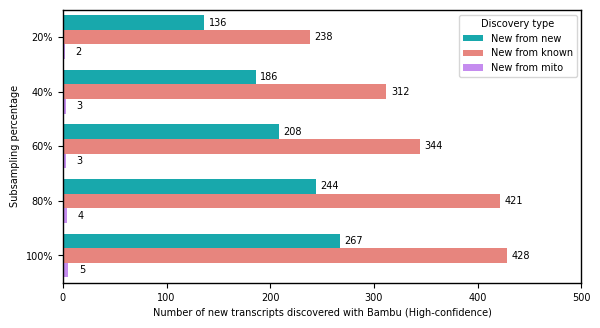

In [45]:
## Make no filter countsplot and save

ax = sns.barplot(y="Subsampling percentage", x='Number of transcripts', hue='Discovery type', data=df_plot, orient='h',
                  palette=[ggplot2_colors[4], ggplot2_colors[0], ggplot2_colors[6]],
                  hue_order=["New from new", "New from known", "New from mito"])


plt.xlim(0,500)

# Adding labels to each bar
for p in ax.patches:
    
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_x() + p.get_width(), p.get_y() + p.get_height()/2), 
                ha='center', va='center', 
                xytext=(10, 0), 
                textcoords='offset points',
                fontsize=7)
    
plt.ylabel("Subsampling percentage")
plt.xlabel("Number of new transcripts discovered with Bambu (High-confidence)")

plt.savefig('../../../figures/1st_rebuttal_figures/discovery_saturation_point/barplot_saturation_point_HF.pdf',
            dpi=600, transparent=True, bbox_inches="tight")